# Report Description Classification

This notebook compares the performance of report classification with preprocessing by Spacy and NLTK, and Complement Naive Bayes and SVM models.

> This notebook is based off Bo's [ski_learn_with_spacy_finetune.ipynb](https://github.com/Code-the-Change-YYC/YW-NLP-Report-Classifier/blob/02ff7a9e7f49779c736cbb55edb4e8d2835beddd/notebooks/machine_learning/ski_learn_with_spacy_finetune.ipynb)

## Data Specification

This notebook was tested with data preprocessed by `ReportData` with 335 training examples.

> Lemmatization in preprocessing **is not used** as it is performed in the notebook.

Commit tested at: `a9ed0b8b4587410fd969bce6481057b205d9049e`

## Results Summary

The results of multiple preprocessing combinations are summarized here:

![image.png](./images/description_classification_results_no_weights.png)
> Placeholder used is `'someone'`. w/o placeholders for scrubadub uses `'{{}}'` entities, and for spacy it uses `'*'` entities

## Setup

If running this notebook in Google Colab, upload the requested files and install the dependencies. Otherwise update the path to allow for necessary imports.

In [1]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import files
    required_files = ['requirements.txt', 'data-processed.csv', 'report_data.py', 'report_data_d.py', 'incident_types_d.py']
    for file in required_files:
        print(f'Upload {file}')
        files.upload()

    !pip install -r requirements.txt
else:
    from os import path
    root = path.abspath(path.join('..', '..'))
    sys.path.append(root)
    
    preprocess = path.join(root, 'preprocess')
    sys.path.append(preprocess)
    
    incident_types = path.join(preprocess, 'incident_types')
    sys.path.append(incident_types)
    
    models = path.join(root, 'models')
    sys.path.append(models)

In [2]:
from tempfile import mkdtemp

import en_core_web_lg
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import set_config
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    plot_confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight

import weight_paths
from incident_types_d import IncidentType
from report_data import ReportData
from report_data_d import ColName

set_config(display="diagram")

Download NLTK data and models

In [3]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siepp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siepp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\siepp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load Spacy NLP model trained on web documents

In [4]:
nlp = en_core_web_lg.load()

## Preprocessing

NLTK and Spacy versions of preprocessing to remove stop words and non-letter tokens, as well as perform lemmatization.

In [5]:
def spacy_tokenizer(df_sent):
    spy_txt = nlp(df_sent)
    return [
        w.lemma_ if w.lemma_ != "-PRON-" else w.text
        for w in spy_txt
        if not w.is_stop and not w.is_punct
    ]

In [6]:
def nltk_tokenizer(df_sent):
    lemmatizer = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    tokens = word_tokenize(df_sent)
    words = [word.lower() for word in tokens if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]

    return words

Load the data

In [7]:
if IN_COLAB:
    yw_df = ReportData(out_file_path="data-processed.csv").get_processed_data()
else:
    yw_df = ReportData().get_processed_data()[[ColName.DESC, ColName.INC_T1]]

print(yw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ColName.DESC    335 non-null    object
 1   ColName.INC_T1  335 non-null    object
dtypes: object(2)
memory usage: 5.4+ KB
None


Summarize the differences between Spacy and NLTK tokenization

In [8]:
yw_clean = yw_df[ColName.DESC]

print(
    "Spacy tokenization compared to NLTK tokenization on the same report description:\n"
)
spacy_tokens = spacy_tokenizer(yw_clean[0])
nltk_tokens = nltk_tokenizer(yw_clean[0])
print("Items in spacy_tokens but not in nltk_tokens:")
print([x for x in spacy_tokens if x not in nltk_tokens])
print()
print("Items in nltk_tokens but not in spacy_tokens:")
print([x for x in nltk_tokens if x not in spacy_tokens])

Spacy tokenization compared to NLTK tokenization on the same report description:

Items in spacy_tokens but not in nltk_tokens:
['NAME+INITIALS-0', 'make', 'check', 'NAME+INITIALS-0', 'appear', 'NAME+INITIALS-0', 'tell', 'want', 'call', 'initials-1', 'initials-1', 'arrive', 'assess', 'NAME+INITIALS-0', 'state', 'vital', 'appear', 'struggle', 'NAME+INITIALS-0', 'decline', 'go', 'initials-1']

Items in nltk_tokens but not in spacy_tokens:
['could', 'making', 'checked', 'breathing', 'appeared', 'told', 'could', 'wanted', 'called', 'arrived', 'assessed', 'stated', 'vitals', 'appeared', 'struggling', 'declined', 'going']


Use tf-idf with our Spacy tokenizer to vectorize the data. Note:

- We match single character alphanumeric words instead of the default minimum double character.
- We use both uni-grams and bi-grams, this gives more features and preserves some possibly important ordering. See [here](https://scikit-learn.org/stable/modules/feature_extraction.html?highlight=tfidf#common-vectorizer-usage) for an example.
- We set `min_df` to filter odd words that don't appear often. We only need to consider more common word patterns and filter out the odd words.

In [9]:
word_vec = TfidfVectorizer(
    tokenizer=spacy_tokenizer, token_pattern=r"\b\w+\b", ngram_range=(1, 2), min_df=2
)

Split data into training and test data. The `random_state` of `32` has been manually optimized for our data.

In [10]:
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(
    yw_clean, yw_df[ColName.INC_T1], train_size=0.75, random_state=32, shuffle=True
)

Assigns each label class a weight according to it's frequency of appearance in the dataset.

In [11]:
def count_weight(labels):
    weight_dict = {lb: 0 for lb in set(labels)}

    for label in labels:
        weight_dict[label] += 1

    return weight_dict

Compute sample weights for each example, giving higher frequency examples more weight.

In [12]:
weight_train = compute_sample_weight(count_weight(y_train_set), y_train_set)
weight_test = compute_sample_weight(count_weight(y_test_set), y_test_set)

## Training and Evaluation

### Manually Optimized Model Evaluation

Initialize and fit the models.
> NOTE: Using sample weights with CNB significantly decreases the accuracy, this could be related to the inner workings of the algorithm.

In [13]:
cnb_cache = mkdtemp()
cnb = make_pipeline(word_vec, ComplementNB(), memory=cnb_cache)
cnb.fit(X_train_set, y_train_set)

Pipeline(memory='C:\\Users\\siepp\\AppData\\Local\\Temp\\tmp25wa3g4o',
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 token_pattern='\\b\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x00000181BA46CD30>)),
                ('complementnb', ComplementNB())])

In [14]:
svm_cache = mkdtemp()
svm = make_pipeline(word_vec, SVC(), memory=svm_cache)
svm.fit(X_train_set, y_train_set, svc__sample_weight=weight_train)

Pipeline(memory='C:\\Users\\siepp\\AppData\\Local\\Temp\\tmputosp6ln',
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 token_pattern='\\b\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x00000181BA46CD30>)),
                ('svc', SVC())])

> NOTE: Using `sample_weight=weight_test` in our metrics calculations makes samples which are more prevalent in our data contribute more to the overall score.

In [15]:
predicted_test = cnb.predict(X_test_set)
predicted_train = cnb.predict(X_train_set)
test_score = accuracy_score(y_test_set, predicted_test, sample_weight=weight_test)
train_score = accuracy_score(y_train_set, predicted_train, sample_weight=weight_train)
test_balance = balanced_accuracy_score(
    y_test_set, predicted_test, sample_weight=weight_test
)
train_balance = balanced_accuracy_score(
    y_train_set, predicted_train, sample_weight=weight_train
)

print("Complement NB test accuracy score is: {:.2%} \n".format(test_score))
print("Complement NB train accuracy score is: {:.2%} \n".format(train_score))
print("Complement NB test balanced accuracy score is: {:.2%} \n".format(test_balance))
print("Complement NB train balanced accuracy score is: {:.2%} \n".format(train_balance))

Complement NB test accuracy score is: 89.38% 

Complement NB train accuracy score is: 96.99% 

Complement NB test balanced accuracy score is: 25.18% 

Complement NB train balanced accuracy score is: 82.09% 



In [16]:
predicted_test = svm.predict(X_test_set)
predicted_train = svm.predict(X_train_set)
test_score = accuracy_score(y_test_set, predicted_test, sample_weight=weight_test)
train_score = accuracy_score(y_train_set, predicted_train, sample_weight=weight_train)
test_balance = balanced_accuracy_score(
    y_test_set, predicted_test, sample_weight=weight_test
)
train_balance = balanced_accuracy_score(
    y_train_set, predicted_train, sample_weight=weight_train
)

print("SVM-C test accuracy score is :{:.2%} \n".format(test_score))
print("SVM-C train accuracy score is :{:.2%} \n".format(train_score))
print("SVM-C test balanced accuracy score is :{:.2%} \n".format(test_balance))
print("SVM-C train balanced accuracy score is :{:.2%} \n".format(train_balance))

SVM-C test accuracy score is :92.25% 

SVM-C train accuracy score is :99.80% 

SVM-C test balanced accuracy score is :19.50% 

SVM-C train balanced accuracy score is :83.05% 



Text(0.5, 1.0, 'Complement NB confusion matrix on test set with normalization')

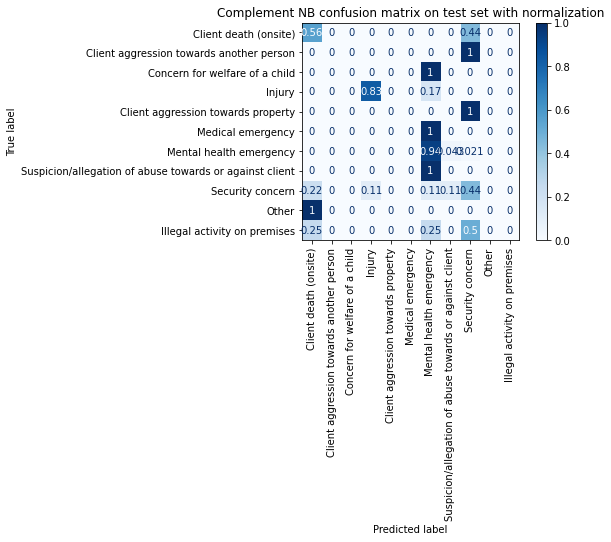

In [17]:
test_class = set(y_test_set)
disp = plot_confusion_matrix(
    cnb,
    X_test_set,
    y_test_set,
    sample_weight=weight_test,
    normalize="true",
    display_labels=test_class,
    cmap=plt.cm.Blues,
    xticks_rotation="vertical",
)
title = "Complement NB confusion matrix on test set with normalization"
disp.ax_.set_title(title)

Text(0.5, 1.0, 'SVM-C confusion matrix on test set with normalization')

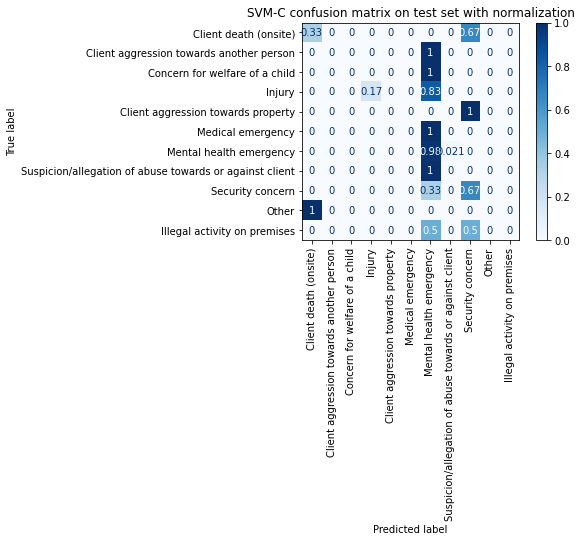

In [18]:
disp = plot_confusion_matrix(
    svm,
    X_test_set,
    y_test_set,
    sample_weight=weight_test,
    normalize="true",
    display_labels=test_class,
    cmap=plt.cm.Blues,
    xticks_rotation="vertical",
)
title = "SVM-C confusion matrix on test set with normalization"
disp.ax_.set_title(title)

In [19]:
predicted_test = cnb.predict(X_test_set)
labels = [e.value for e in IncidentType]
print("Complement NB test set classification report\n")
print(
    classification_report(
        y_test_set,
        predicted_test,
        sample_weight=weight_test,
        labels=labels,
        target_names=labels,
    )
)

Complement NB test set classification report

                                                             precision    recall  f1-score   support

                   Client aggression towards another person       0.66      0.56      0.60      81.0
                         Client aggression towards property       0.00      0.00      0.00       1.0
                             Concern for welfare of a child       0.77      0.83      0.80      36.0
                               Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                                          Medical emergency       0.99      0.94      0.96    2209.0
                                    Mental health emergency       0.00      0.00      0.00       4.0
                                                      Other       0.28      0.44      0.34      81.0
                                           Security concern       0.00      0.00      0.00       1.0
                                            

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
predicted_test = svm.predict(X_test_set)

print("SVM-C test set classification report\n")
print(
    classification_report(
        y_test_set,
        predicted_test,
        sample_weight=weight_test,
        labels=labels,
        target_names=labels,
    )
)

SVM-C test set classification report

                                                             precision    recall  f1-score   support

                   Client aggression towards another person       0.96      0.33      0.50      81.0
                         Client aggression towards property       0.00      0.00      0.00       1.0
                             Concern for welfare of a child       1.00      0.17      0.29      36.0
                               Homicide (Threat or attempt)       0.00      0.00      0.00       0.0
                                          Medical emergency       0.97      0.98      0.97    2209.0
                                    Mental health emergency       0.00      0.00      0.00       4.0
                                                      Other       0.46      0.67      0.55      81.0
                                           Security concern       0.00      0.00      0.00       1.0
                                            Suicide 

### Cross Validated Model Evaluation

Detailed parameter fine tuning based on balanced accuracy and accuracy score on SVC.

In [21]:
# Save the encoded input as it takes too long to generate each grid search
X_train_enc = word_vec.fit_transform(X_train_set)

In [22]:
svc_params_list = {
    "C": np.linspace(3, 0, num=9, endpoint=False),
    "kernel": ["sigmoid"],  # ["linear", "poly", "sigmoid"],
    "gamma": ["scale"],  # ["scale", "auto"],
    "decision_function_shape": [
        "ovo"
    ],  # Multi-class is always handled with one-vs-one # ["ovo", "ovr"],
    "class_weight": ["balanced"],  # ["balanced", None],
}

In [23]:
svm_op = GridSearchCV(svm.named_steps['svc'], param_grid=svc_params_list)
svm_op.fit(X_train_enc, y_train_set, sample_weight=weight_train)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(estimator=SVC(),
             param_grid={'C': array([3.        , 2.66666667, 2.33333333, 2.        , 1.66666667,
       1.33333333, 1.        , 0.66666667, 0.33333333]),
                         'class_weight': ['balanced'],
                         'decision_function_shape': ['ovo'], 'gamma': ['scale'],
                         'kernel': ['sigmoid']})

In [24]:
svm_op.best_params_

{'C': 3.0,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'kernel': 'sigmoid'}

In [25]:
scoring = ["recall_weighted", "precision_weighted", "balanced_accuracy", "accuracy"]
fit_params = {"sample_weight": weight_train}

cv_s = cross_validate(
    svm_op.best_estimator_,  # change to svm variable to see differences from fine tuning
    X_train_enc,
    y_train_set,
    scoring=scoring,
    fit_params=fit_params,
)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sie

In [26]:
cnb_op = GridSearchCV(
    cnb.named_steps['complementnb'], param_grid={"alpha": np.linspace(3, 0, num=50, endpoint=False)}
)
cnb_op.fit(X_train_enc, y_train_set)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(estimator=ComplementNB(),
             param_grid={'alpha': array([3.  , 2.94, 2.88, 2.82, 2.76, 2.7 , 2.64, 2.58, 2.52, 2.46, 2.4 ,
       2.34, 2.28, 2.22, 2.16, 2.1 , 2.04, 1.98, 1.92, 1.86, 1.8 , 1.74,
       1.68, 1.62, 1.56, 1.5 , 1.44, 1.38, 1.32, 1.26, 1.2 , 1.14, 1.08,
       1.02, 0.96, 0.9 , 0.84, 0.78, 0.72, 0.66, 0.6 , 0.54, 0.48, 0.42,
       0.36, 0.3 , 0.24, 0.18, 0.12, 0.06])})

In [27]:
cnb_op.best_params_

{'alpha': 1.26}

In [28]:
cv_b = cross_validate(cnb_op.best_estimator_, X_train_enc, y_train_set, scoring=scoring)

c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\siepp\desktop\school\code-the-change\yw-nlp-report-classifier\.env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

In [29]:
def compare_score(score: str):
    np.set_printoptions(precision=2)
    print(f"{score}:")
    cnb = cv_b[f"test_{score}"]
    print("CNB\t", cnb)
    print("CNB max\t", cnb.max())
    svm = cv_s[f"test_{score}"]
    print("SVM-C\t", svm)
    print("SVM max\t", svm.max())


for score in scoring:
    compare_score(score)
    print()

print(
    "time to fit(train):\nCNB\t{:.4f}\nSVM-C\t{:.4f}\n".format(
        np.average(cv_b["fit_time"]), np.average(cv_s["fit_time"])
    )
)
print(
    "time to score:\nCNB\t{:.4f}\nSVM-C\t{:.4f}\n".format(
        np.average(cv_b["score_time"]), np.average(cv_s["score_time"])
    )
)

recall_weighted:
CNB	 [0.53 0.6  0.64 0.76 0.64]
CNB max	 0.76
SVM-C	 [0.55 0.58 0.58 0.64 0.62]
SVM max	 0.64

precision_weighted:
CNB	 [0.43 0.5  0.56 0.71 0.57]
CNB max	 0.7116444444444444
SVM-C	 [0.52 0.54 0.56 0.6  0.52]
SVM max	 0.6036666666666667

balanced_accuracy:
CNB	 [0.4  0.45 0.37 0.54 0.33]
CNB max	 0.5375
SVM-C	 [0.37 0.43 0.32 0.46 0.27]
SVM max	 0.45757575757575764

accuracy:
CNB	 [0.53 0.6  0.64 0.76 0.64]
CNB max	 0.76
SVM-C	 [0.55 0.58 0.58 0.64 0.62]
SVM max	 0.64

time to fit(train):
CNB	0.0028
SVM-C	0.0430

time to score:
CNB	0.0034
SVM-C	0.0066



## Model Saving

> NOTE: In Colab the files will be saved to the current directory, download these to your local `model_output` folder.

In [30]:
import pickle


def get_model_output_path(file_name: str, full_path: str) -> str:
    return full_path if not IN_COLAB else f"./{file_name}"


def save_model(model, file_name: str, full_path: str):
    with open(get_model_output_path(file_name, full_path), "wb") as f:
        pickle.dump(model, f)

for cv, pipe in [(svm_op, svm), (cnb_op, cnb)]:
    pipe.steps[-1][1].set_params(**cv.best_params_)

save_model(cnb, weight_paths.cnb_file_name, weight_paths.cnb)
save_model(svm, weight_paths.svm_file_name, weight_paths.svm)